# Notebook to study short term persistence from multiple exposures in a single visit 


In [1]:
from astropy.io import fits
import glob, os, shutil, pickle, bz2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import sigmaclip
from scipy.optimize import curve_fit
from scipy.special import gammaincc, gamma
from astropy.wcs import WCS
from astropy.stats import histogram
from itertools import product
from multiprocessing import Pool

%matplotlib notebook

In [2]:
pwd

'/grp/hst/wfc3n/vbajaj/short_term_pers/short_term_persistence/Pixel_based'

In [3]:
# The project dir 
pdir = '/user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence/'

#The mosaic dir
mdir = pdir+'/Mosaic_hi_res_folder/'

#The dir to save/load the Persistence curves dataframes
sdir = pdir+'PD_dataframes_dir'

In [4]:
#Single and double exponential models to be fitted to the data

def decay1(t,a1,t1):
    e1 = a1*np.exp(-t/t1)
    return e1

def intdec1(t,a1,t1):
    tu = t[1:]
    td = t[:-1]
    k  = -a1*t1
    return k*(np.exp(-tu/t1)-np.exp(-td/t1))/(tu-td)
    
def decay2(t,a1,t1,a2,t2):
    e1 = a1*np.exp(-t/t1)
    e2 = a2*np.exp(-t/t2)
    return e1+e2

def intdec2(t,a1,t1,a2,t2):
    tu = t[1:]
    td = t[:-1]
    k1,k2  = -a1*t1, - a2*t2
    
    return k1*(np.exp(-tu/t1)-np.exp(-td/t1))/(tu-td) + k2*(np.exp(-tu/t2)-np.exp(-td/t2))/(tu-td)

#Single exponential models plus a constant

def intdec1_plusconst(t,a1,t1,q):
    tu = t[1:]
    td = t[:-1]
    k  = -a1*t1
    return k*(np.exp(-tu/t1)-np.exp(-td/t1))/(tu-td) +q

def dec1_plusconst(t,a1,t1,q):
    e1 = a1*np.exp(-t/t1)
    return e1+q


#Shifted power law model

def shpwl(t,t0,A,index):
    return A * ((t+t0)/1000)**index

def intshpwl(t,t0,A,index):
    tu = t[1:]
    td = t[:-1]

    if (index == -1.):
        return A*np.log( (tu+t0)/(td+t0) )
    else:
        return A/(1+index) * ( ((tu+t0)/1000)**(1+index) - ((td+t0)/1000)**(1+index) )/(tu-td)
    
    
#Schechter like model

def schechter(t,phi,alpha,tstar):
    x = t/tstar
    return phi*(x**alpha)*np.exp(-x)

def intschechter(t,phi,alpha,tstar):
    x = t/tstar

    tu = x[1:]
    td = x[:-1]

    g1 = gammaincc(alpha+1,td)
    g2 = gammaincc(alpha+1,tu)
    
    diff = gamma(alpha+1)*(g1-g2)
    
    return phi*diff

In [5]:
#Geometric median calculation function

from scipy.spatial.distance import cdist, euclidean

def geometric_median(X, eps=1e-5):
    y = np.mean(X, 0)

    while True:
        D = cdist(X, [y])
        nonzeros = (D != 0)[:, 0]

        Dinv = 1 / D[nonzeros]
        Dinvs = np.sum(Dinv)
        W = Dinv / Dinvs
        T = np.sum(W * X[nonzeros], 0)

        num_zeros = len(X) - np.sum(nonzeros)
        if num_zeros == 0:
            y1 = T
        elif num_zeros == len(X):
            return y
        else:
            R = (T - y) * Dinvs
            r = np.linalg.norm(R)
            rinv = 0 if r == 0 else num_zeros/r
            y1 = max(0, 1-rinv)*T + min(1, rinv)*y

        if euclidean(y, y1) < eps:
            return y1, D

        y = y1



In [6]:
#Read files, make sure they are sorted by EXPSTART

sflts= []

for vis in ['1','2','3']:
    wdir = pdir+'/14016_data/Visit0'+vis+'/'
    flts = glob.glob(wdir+'*_flt.fits')
    print('***************')
    starttimes = []
    endtimes   = []
    imagetypes = []
    for flt in flts:
        starttimes.append(fits.getheader(flt,0)['EXPSTART'])
        endtimes.append(fits.getheader(flt,0)['EXPEND'])
        imagetypes.append(fits.getheader(flt,0)['IMAGETYP'])
    
    ii = np.argsort(starttimes)
    for jj in range(len(flts)):
        print(starttimes[ii[jj]],endtimes[ii[jj]],(starttimes[ii[jj]]-endtimes[ii[jj]])*24*3600,imagetypes[ii[jj]],flts[ii[jj]])


    sflts.append([flts[i] for i in ii])



***************
57247.89789127 57247.90197646 -352.96041641850024 EXT /user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence//14016_data/Visit01/icrr01y7q_flt.fits
57247.9027409 57247.90682572 -352.9284480493516 EXT /user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence//14016_data/Visit01/icrr01y8q_flt.fits
57247.90759053 57247.91167535 -352.9284480493516 EXT /user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence//14016_data/Visit01/icrr01yaq_flt.fits
57247.91243979 57247.91652498 -352.9604157898575 EXT /user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence//14016_data/Visit01/icrr01ycq_flt.fits
57247.91728942 57247.9213746 -352.9595520347357 EXT /user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence//14016_data/Visit01/icrr01yeq_flt.fits
57247.92213905 57247.92622386 -352.927583665587 EXT /user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence

<IPython.core.display.Javascript object>


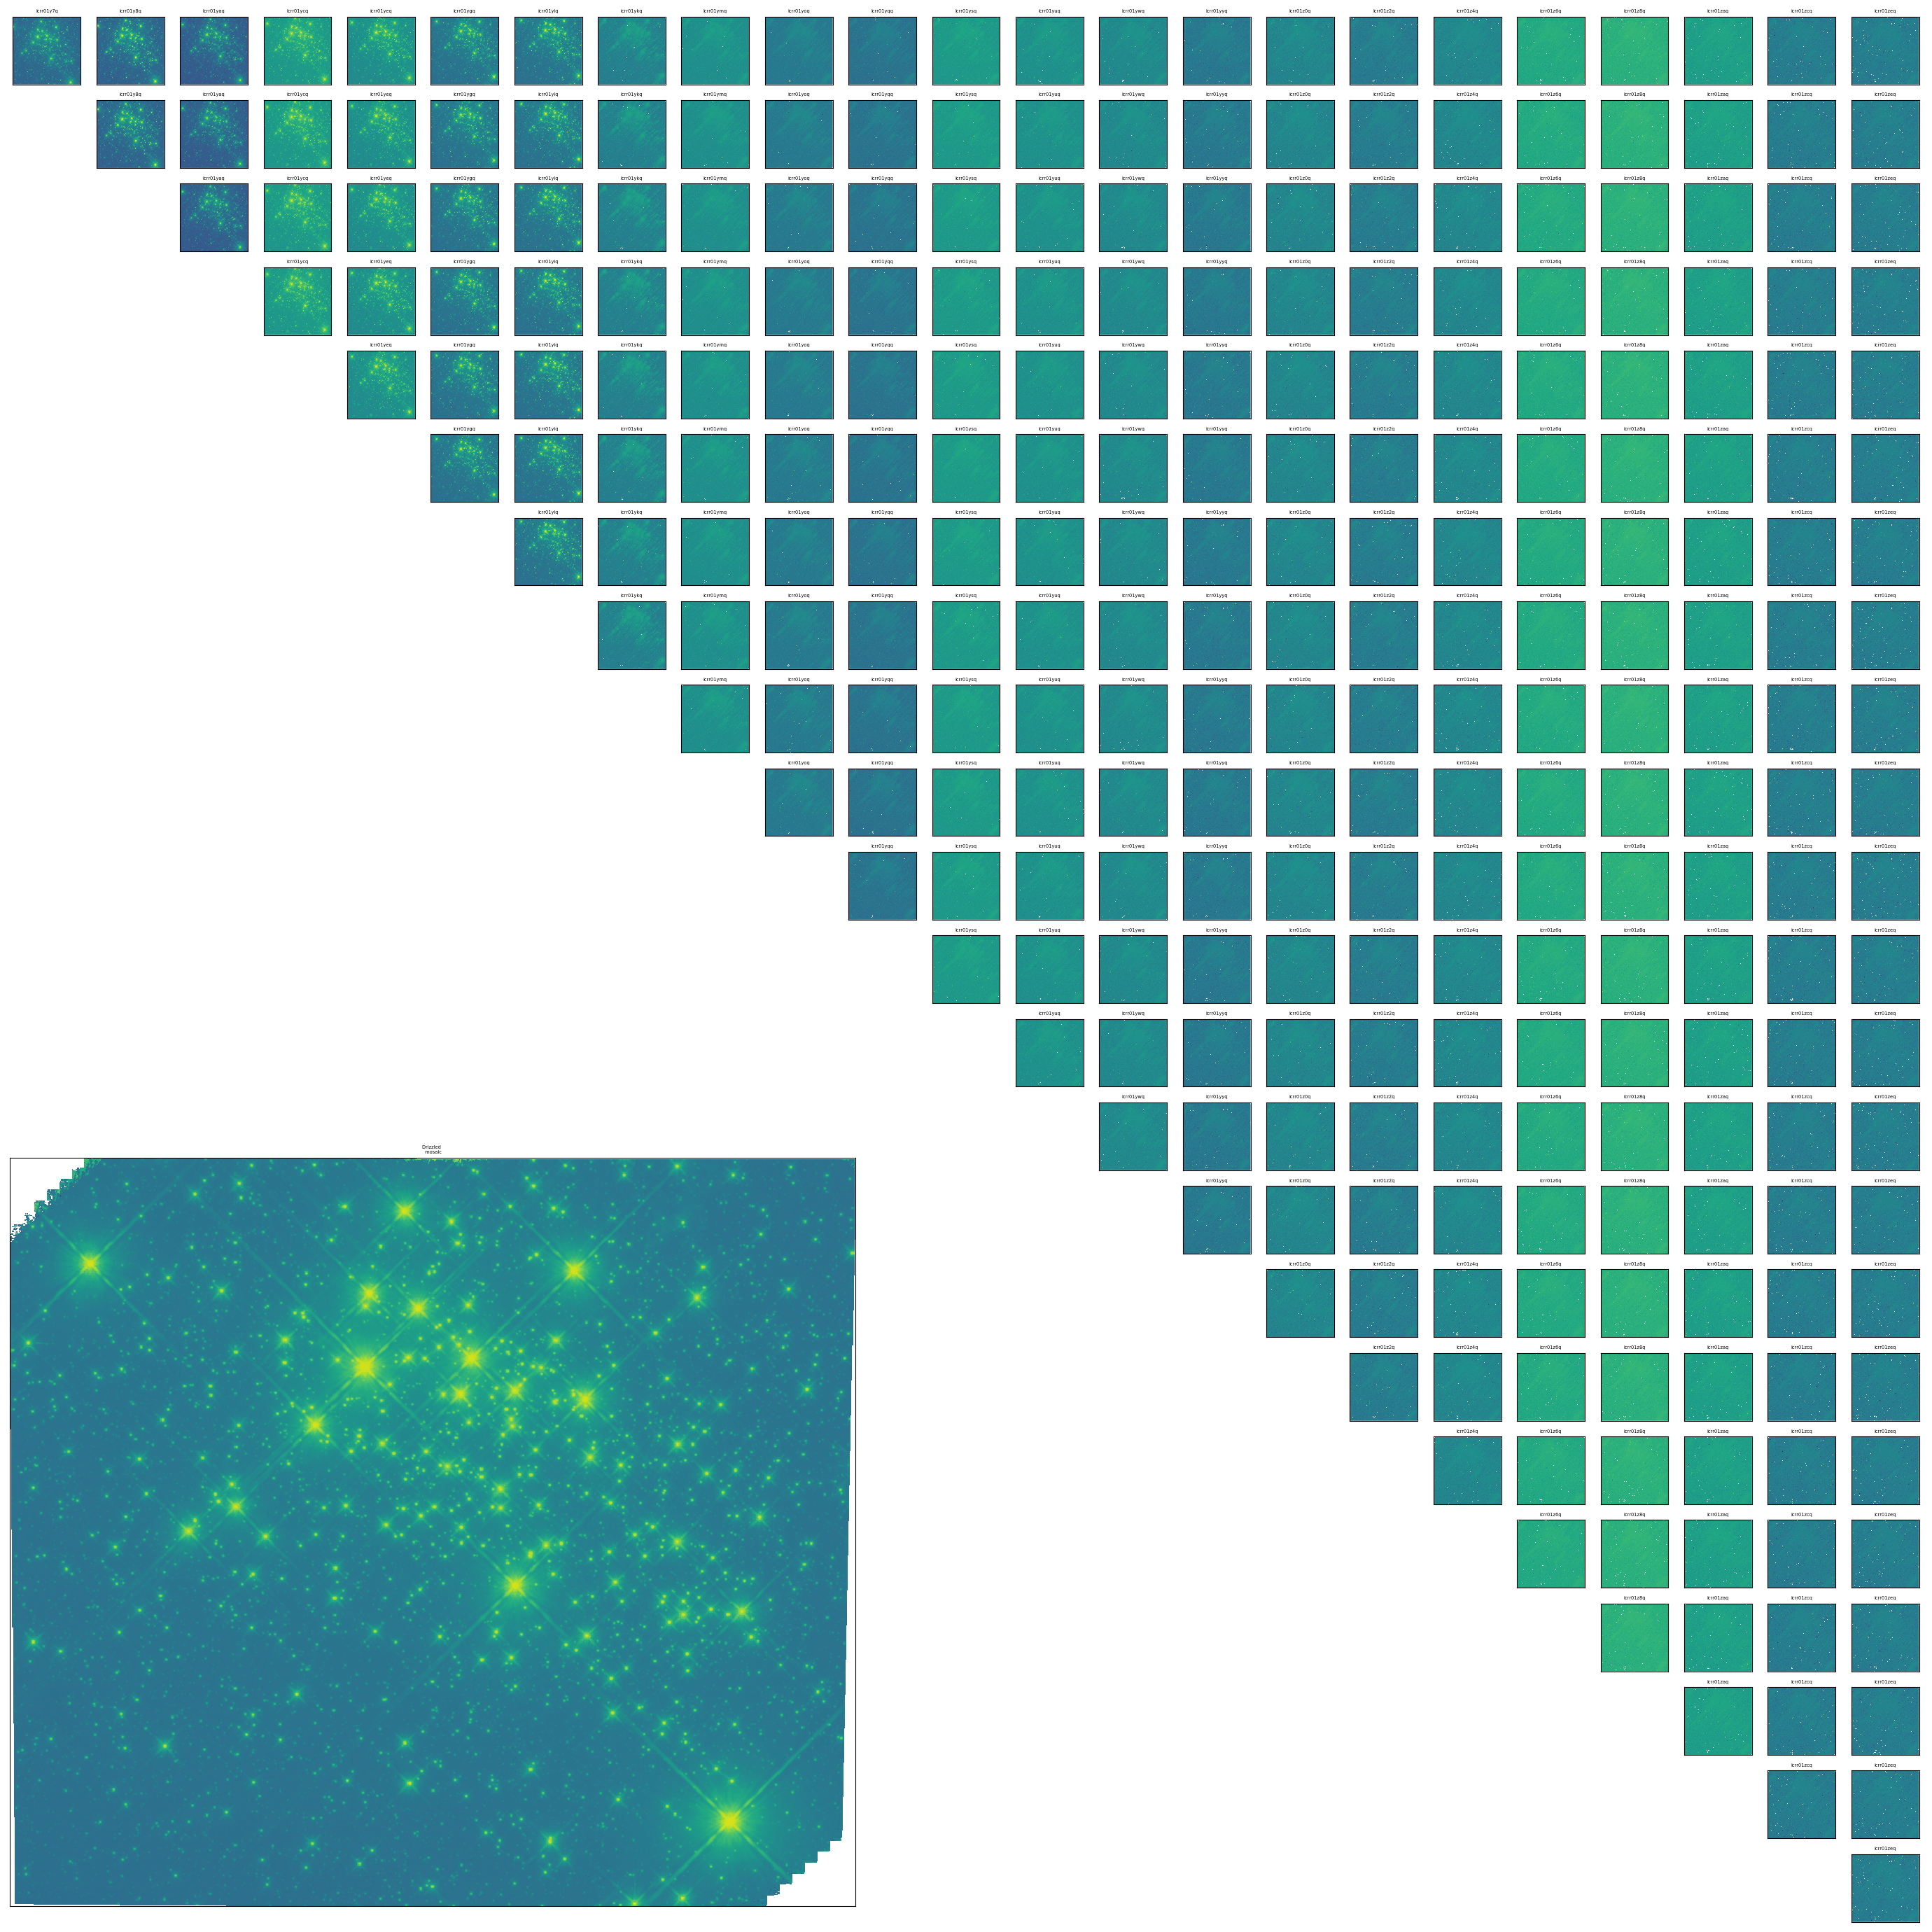

/user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence//14016_data/Visit01/icrr01y7q_flt.fits clipped mean:  -15.6977
/user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence//14016_data/Visit01/icrr01y8q_flt.fits clipped mean:  -16.9497
/user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence//14016_data/Visit01/icrr01yaq_flt.fits clipped mean:  -16.8376
/user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence//14016_data/Visit01/icrr01ycq_flt.fits clipped mean:  -18.1507
/user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence//14016_data/Visit01/icrr01yeq_flt.fits clipped mean:  -18.0486
/user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence//14016_data/Visit01/icrr01ygq_flt.fits clipped mean:  -18.9662
/user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence//14016_data/Visit01/icrr01yiq_flt.fits clipped mean:  -18.2426
/user/

In [7]:
# Choose which visit to work on

visit_index = 0
vsflts = sflts[visit_index]

# If in a hurry, shorten the list for faster analysis

#vsflts = vsflts[0:10]

#plot all exposures multiple times for visualization of the selected pixels

sf=1.5
fig = plt.figure(figsize=(sf*len(vsflts),sf*len(vsflts)))

ax = []
for i,flt in enumerate(vsflts):
    im = fits.getdata(flt)
    c, low, upp = sigmaclip(im, 2.5,3)
    mn = np.amin(c)
    print(flt,'clipped mean: ',mn)
    j = -1
    while j < i: 
        j+=1
        ax.append(plt.subplot(len(vsflts),len(vsflts),j*len(vsflts)+1+i))
        ax[-1].imshow(np.log10(im-mn),cmap='viridis', interpolation='none', origin='lower')
        ax[-1].set_title(flt[-18:-9],fontsize=6)
        ax[-1].get_xaxis().set_ticks([])
        ax[-1].get_yaxis().set_ticks([])
        
        
# Read the mosaic file and plot it

plt.tight_layout()
mosaic = fits.open(mdir+'/F140W_Mosaic_WFC3_IR_drz.fits')

ax.append(plt.subplot(len(vsflts),len(vsflts),j*len(vsflts)+1))

pos1 = ax[-1].get_position() # get the original position 
pos2 = [pos1.x0, pos1.y0,  pos1.width * len(vsflts)/2., pos1.height * len(vsflts)/2.] 
ax[-1].set_position(pos2) # set a new position
ax[-1].get_xaxis().set_ticks([])
ax[-1].get_yaxis().set_ticks([])
        
c, low, upp = sigmaclip(mosaic[1].data[np.where(np.isfinite(mosaic[1].data))], 2.5,3)
mn = np.amin(c)
im = ax[-1].imshow(np.log10(mosaic[1].data-mn),cmap='viridis', interpolation='none', origin='lower')
ax[-1].set_title('Drizzled \n mosaic',fontsize=6)



In [8]:
#Create the wcs objects for the AD mosaic and flts 

w_mosaic = WCS(mosaic[1].header)

w_vsflts = []
for vsflt in vsflts:
    w_vsflts.append(WCS(fits.getheader(vsflt,1)))

In [9]:
# Define a function that takes the vsflts list, the current flt that is being used as stimulus
# and looks for all the pixels with valid stimulus values AND that have valid ramps (i.e. no source, only sky)
# in the following exposures AND that where not stimulated more than 10% of the current stimulus in 
# ANY past exposure

def find_ramps(istim,flts,lev_u,lev_d):
    
    stimdata  = fits.getdata(flts[istim])
    istimgood = (stimdata > lev_d) & (stimdata < lev_u)  
    print('Pixels with potentially right stimuli:',np.sum(istimgood) )

    
    for i,pflt in enumerate(flts[0:istim]):
        persdata = fits.getdata(pflt)
        if (fits.getheader(pflt,0)['IMAGETYP'] == 'EXT'):  
            #msky = np.nanmean(sigmaclip(persdata,2.5,2.5)[0])
            #ssky = np.nanstd(sigmaclip(persdata,2.5,2.5)[0])
            #istimgood = istimgood & (persdata <msky+1*ssky) & (persdata >msky-1*ssky)    
            istimgood = istimgood & (persdata < 0.1*stimdata)  

            
    print('Pixels with really right stimuli:',np.sum(istimgood) )
    
    
    icount    = np.zeros_like(stimdata,dtype=np.int_)
    iprev     = istimgood
    for i,pflt in enumerate(flts[istim+1:]):
    
        persdata = fits.getdata(pflt)
        
        if (fits.getheader(pflt,0)['IMAGETYP'] == 'EXT'):  
            msky = np.nanmean(sigmaclip(persdata,2.5,2.5)[0])
            ssky = np.nanstd(sigmaclip(persdata,2.5,2.5)[0])
            iskycurr = (persdata <msky+1*ssky) & (persdata >msky-1*ssky)    
        
        elif (fits.getheader(pflt,0)['IMAGETYP'] == 'DARK'):
            iskycurr = np.ones_like(persdata,dtype=np.bool_)
        else:
            print('Wrong image type')
            assert False
        
        igood = istimgood & iskycurr & iprev
        iprev = igood
        
        icount[igood] += 1

        print('Pixels with ramps extending for at least',i+1,' exposures:', igood.sum())
        
        if (np.sum(igood) == 0):
            break
       
          
    return icount

In [10]:
# Dedfine a function to get the sky value in the cureent flt pixel, but measured form the AD mosaic

def getskyfrommosaic(wcsAD, wcsFLT, x, y, dxgrid, dygrid, skyrad_o,skyrad_i,drz_fin,mask_sky_contam,mosaic):

    coords = wcsAD.all_world2pix(wcsFLT.all_pix2world(np.array([[x,y]],dtype=np.float_),0),0) 
    dx = coords[0,0]
    dy = coords[0,1]
    
    dst = np.sqrt((dxgrid-dx)**2 + (dygrid-dy)**2)
    msk = (dst<skyrad_o) & (dst > skyrad_i) & drz_fin & mask_sky_contam 
    skyarr = mosaic[1].data[msk]
    cskyarr,l,u = sigmaclip(skyarr,2.,2.)
    return np.nanmean(cskyarr)

# Similar but for darks

def getbackgroundfordarks (x, y, xgrid, ygrid, skyrad_o,skyrad_i, fltdata):

    dst = np.sqrt((xgrid-x)**2 + (ygrid-y)**2)
    msk = (dst<skyrad_o) & (dst > skyrad_i)
    skyarr = fltdata[msk]
    cskyarr,l,u = sigmaclip(skyarr,2.,2.)
    return np.nanmean(cskyarr)



In [11]:
#Define the stimuli e-/s level to identify the ramps

lev_u = np.inf
lev_d = 3.5e4

# Define the pixel grid (to trasform indices in x,y positions)
xgrid,ygrid = np.meshgrid( np.arange(fits.getdata(vsflts[0],1).shape[1]) ,np.arange(fits.getdata(vsflts[0],1).shape[0]))
dxgrid,dygrid = np.meshgrid( np.arange(mosaic[1].data.shape[1]) ,np.arange(mosaic[1].data.shape[0]))

drz_fin = np.isfinite(mosaic[1].data)

msky_d = np.nanmean(sigmaclip(mosaic[1].data[drz_fin],2.5,2.5)[0])
ssky_d = np.nanstd(sigmaclip(mosaic[1].data[drz_fin],2.5,2.5)[0])
mask_sky_contam = (mosaic[1].data <msky_d+3*ssky_d) & (mosaic[1].data >msky_d-3*ssky_d)

skyrad_o = 25
skyrad_i = 15



In [12]:
# Create the numoy arrays containg the iam and flt data as well
# as the arrays of metadata

ima_scis  = []
ima_errs  = []
ima_times = [] 
flts      = []
tendMJDs  = []
tstrMJDs  = []
imtyps    = []
nsamps    = []
sampseqs = []

for vsflt in vsflts:
    ima = fits.open(vsflt.replace('_flt','_ima'))
    nsamps.append(ima[0].header['NSAMP'])
    sampseqs.append(ima[0].header['SAMP_SEQ'])
    for k in range(nsamps[-1]):
        
        ima_scis.append(ima['SCI',k+1].data[5:-5,5:-5])
        ima_errs.append(ima['ERR',k+1].data[5:-5,5:-5])
        ima_times.append(ima['TIME',k+1].header['PIXVALUE'])
      
    flt = fits.open(vsflt)
    flts.append(flt[1].data)
    
    tendMJDs.append(flt[0].header['EXPEND'])
    tstrMJDs.append(flt[0].header['EXPSTART'])
    imtyps.append(flt[0].header['IMAGETYP'])
    flt.close()
    ima.close()

ima_scis  = np.asarray(ima_scis)
ima_errs  = np.asarray(ima_errs)
ima_times = np.asarray(ima_times)
flts      = np.asarray(flts)
tendMJDs  = np.asarray(tendMJDs)
tstrMJDs  = np.asarray(tstrMJDs)
imtyps    = np.asarray(imtyps)
nsamps    = np.asarray(nsamps)



In [13]:
def get_sky_and_indices(nz1, nz0, j):
    # Function to get the sky value, as well as calculate the indices needed in the large data cube of IMA reads
    
    
    
    #Get the sky from the drizzled image
    imtyp = imtyps[istim+j]

    if(imtyp == 'EXT'):
        skyhere = getskyfrommosaic(w_mosaic, w_vsflts[istim+j], nz1, nz0, dxgrid, dygrid, skyrad_o,skyrad_i,drz_fin,mask_sky_contam,mosaic)
    elif(imtyp == 'DARK'):
        skyhere = getbackgroundfordarks(nz1, nz0, xgrid, ygrid, skyrad_o,skyrad_i, flts[istim+j,:,:])
    else:
        print('Wrong image type')
        assert False
    
    offset = ( tstrMJDs[istim+j] - tendMJD)*24.*60*60
    ioff = np.sum(nsamps[0:istim+j])
    nsamp = nsamps[istim+j]
    
    k_product = product([nz0], [nz1], [skyhere], [offset], [ioff], [nsamp], [j], range(nsamp-1))
    return list(k_product)

In [14]:
def get_pixel_values(inputs, index):
    # # function to extract the values from the IMA cube and IMA metadata arrays
    
    nz0, nz1, skyhere, offset, ioff, nsamp, j, k = inputs
    ll = index
    te = ima_times[ioff+k]
    ts = ima_times[ioff+k+1]

    tfromstim = te + offset

    tdenom = te - ts  
    meancurr  = (ima_scis[ioff+k,nz0,nz1]*te - ima_scis[ioff+k+1,nz0,nz1]*ts)/tdenom
    stdvcurr  = np.sqrt(np.sum(np.square([ima_errs[ioff+k,nz0,nz1]*te,ima_errs[ioff+k+1,nz0,nz1]*ts])))/tdenom

    #dfl.append([flts[istim,nz0,nz1],nz1,nz0,tfromstim,tdenom,nsamp-k-1,nsamp,meancurr,stdvcurr,skyhere,istim,istim+j])
    storearr[ll,:] = [flts[istim,nz0,nz1],nz1,nz0,tfromstim,tdenom,nsamp-k-1,nsamp,meancurr,stdvcurr,skyhere,istim,istim+j]
#     print(istim,nz0,nz1,nnext,j,k,ioff+k)
#     ll += 1
    perc = 100.*(ll+1.)/(1.*nlines)
    if( ll%modulus ==0. ):
        print(np.int(perc),'% done')
    

In [ ]:
# OLD VERSION, KEPT FOR REFERENCE


# # The dataframe that will host the ramps

# df = pd.DataFrame()
# cols = ['Stim','xpix','ypix','tfromstim','deltat','Read index','NSAMP','meancurr','stdvcurr','ADsky','Ind_stim','Ind_pers']


# for istim,stim in enumerate(vsflts[-2:-1]):

#     print('**********************')
#     print('Doing: ',stim)

#     icount    = find_ramps(istim,vsflts,lev_u,lev_d)
#     tendMJD   = tendMJDs[istim]
    
#     nz     = np.nonzero(icount)    
#     nnexts = icount[nz]
    
#     nlines = 0.
#     for nnext in nnexts:
#         nlines = nlines+np.sum((nsamps-1)[istim+1:istim+1+nnext])

#     print('Number of entries: ',nlines)
#     modulus = np.trunc(nlines/10)
    
#     storearr = np.zeros([nlines,len(cols)])
#     ll = 0 
#     for nz0,nz1,nnext in zip(nz[0],nz[1],nnexts)[:2]:
                   
#         for j in range(1,nnext+1,1):

#             #Get the sky from the drizzled image
#             imtyp = imtyps[istim+j]
            
# #             if(imtyp == 'EXT'):
# #                 skyhere = getskyfrommosaic(w_mosaic, w_vsflts[istim+j], nz1, nz0, dxgrid, dygrid, skyrad_o,skyrad_i,drz_fin,mask_sky_contam,mosaic)
# #             elif(imtyp == 'DARK'):
# #                 skyhere = getbackgroundfordarks(nz1, nz0, xgrid, ygrid, skyrad_o,skyrad_i, flts[istim+j,:,:])
# #             else:
# #                 print('Wrong image type')
# #                 assert False

            
#             offset = ( tstrMJDs[istim+j] - tendMJD)*24.*60*60
#             ioff = np.sum(nsamps[0:istim+j])
#             nsamp = nsamps[istim+j]

#             for k in range(nsamp-1):
        
#                 te = ima_times[ioff+k]
#                 ts = ima_times[ioff+k+1]

#                 tfromstim = te + offset

#                 tdenom = te - ts  
# #                 meancurr  = (ima_scis[ioff+k,nz0,nz1]*te - ima_scis[ioff+k+1,nz0,nz1]*ts)/tdenom
# #                 stdvcurr  = np.sqrt(np.sum(np.square([ima_errs[ioff+k,nz0,nz1]*te,ima_errs[ioff+k+1,nz0,nz1]*ts])))/tdenom

# #                 #dfl.append([flts[istim,nz0,nz1],nz1,nz0,tfromstim,tdenom,nsamp-k-1,nsamp,meancurr,stdvcurr,skyhere,istim,istim+j])
# #                 storearr[ll,:] = [flts[istim,nz0,nz1],nz1,nz0,tfromstim,tdenom,nsamp-k-1,nsamp,meancurr,stdvcurr,skyhere,istim,istim+j]
#                 print(istim,nz0,nz1,nnext,j,k,ioff+k)
#                 ll += 1
#                 perc = 100.*(ll+1.)/(1.*nlines)
#                 if( ll%modulus ==0. ):
#                     print(np.int(perc),'% done')
    
# #     df = df.append(pd.DataFrame(storearr,columns=cols))

In [15]:
df = pd.DataFrame()
cols = ['Stim','xpix','ypix','tfromstim','deltat','Read index','NSAMP','meancurr','stdvcurr','ADsky','Ind_stim','Ind_pers']

# Parallelized version
for istim,stim in enumerate(vsflts[:-1]):

    print('**********************')
    print('Doing: ',stim)

    icount    = find_ramps(istim,vsflts,lev_u,lev_d)
    tendMJD   = tendMJDs[istim]
    
    nz     = np.nonzero(icount)    
    nnexts = icount[nz]
    
    nlines = 0.
    for nnext in nnexts:
        nlines = nlines+np.sum((nsamps-1)[istim+1:istim+1+nnext])

    print('Number of entries: ',nlines)
    modulus = np.trunc(nlines/10)
    
    storearr = np.zeros([nlines,len(cols)])
    ll = 0 
    flt_big_index = []
    for nz0,nz1,nnext in list(zip(nz[0],nz[1],nnexts)):
        prod = product([nz0], [nz1], range(1,nnext+1,1))
        flt_big_index += list(prod)
    
    derp = Pool(8).starmap(get_sky_and_indices, flt_big_index)
    ima_big_index = []
    for block in derp:
        ima_big_index += block
    Pool(8).starmap(get_pixel_values,zip(ima_big_index,range(int(nlines))))
    

    

            
#             offset = ( tstrMJDs[istim+j] - tendMJD)*24.*60*60
#             ioff = np.sum(nsamps[0:istim+j])
#             nsamp = nsamps[istim+j]

#             for k in range(nsamp-1):
        
#                 te = ima_times[ioff+k]
#                 ts = ima_times[ioff+k+1]

#                 tfromstim = te + offset

#                 tdenom = te - ts  
# #                 meancurr  = (ima_scis[ioff+k,nz0,nz1]*te - ima_scis[ioff+k+1,nz0,nz1]*ts)/tdenom
# #                 stdvcurr  = np.sqrt(np.sum(np.square([ima_errs[ioff+k,nz0,nz1]*te,ima_errs[ioff+k+1,nz0,nz1]*ts])))/tdenom

# #                 #dfl.append([flts[istim,nz0,nz1],nz1,nz0,tfromstim,tdenom,nsamp-k-1,nsamp,meancurr,stdvcurr,skyhere,istim,istim+j])
# #                 storearr[ll,:] = [flts[istim,nz0,nz1],nz1,nz0,tfromstim,tdenom,nsamp-k-1,nsamp,meancurr,stdvcurr,skyhere,istim,istim+j]
#                 print(istim,nz0,nz1,nnext,j,k,ioff+k)
#                 ll += 1
#                 perc = 100.*(ll+1.)/(1.*nlines)
#                 if( ll%modulus ==0. ):
#                     print(np.int(perc),'% done')
    
# #     df = df.append(pd.DataFrame(storearr,columns=cols))

**********************
Doing:  /user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence//14016_data/Visit01/icrr01y7q_flt.fits
Pixels with potentially right stimuli: 2566
Pixels with really right stimuli: 2566
Pixels with ramps extending for at least 1  exposures: 88
Pixels with ramps extending for at least 2  exposures: 70
Pixels with ramps extending for at least 3  exposures: 48
Pixels with ramps extending for at least 4  exposures: 38
Pixels with ramps extending for at least 5  exposures: 34
Pixels with ramps extending for at least 6  exposures: 28
Pixels with ramps extending for at least 7  exposures: 28
Pixels with ramps extending for at least 8  exposures: 28
Pixels with ramps extending for at least 9  exposures: 28
Pixels with ramps extending for at least 10  exposures: 28
Pixels with ramps extending for at least 11  exposures: 28
Pixels with ramps extending for at least 12  exposures: 28
Pixels with ramps extending for at least 13  exposures: 28
Pixels wit

/Users/vbajaj/anaconda2/envs/astroconda3/lib/python3.4/site-packages/ipykernel/__main__.py:23: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/vbajaj/anaconda2/envs/astroconda3/lib/python3.4/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/vbajaj/anaconda2/envs/astroconda3/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/vbajaj/anaconda2/envs/astroconda3/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/vbajaj/anaconda2/envs/astroconda3/lib/python3.4/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", Runt

0 % done
10 % done
19 % done
39 % done
29 % done
59 % done
69 % done
49 % done
79 % done
99 % done
89 % done
**********************
Doing:  /user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence//14016_data/Visit01/icrr01y8q_flt.fits
Pixels with potentially right stimuli: 2571
Pixels with really right stimuli: 2404
Pixels with ramps extending for at least 1  exposures: 97
Pixels with ramps extending for at least 2  exposures: 74
Pixels with ramps extending for at least 3  exposures: 53
Pixels with ramps extending for at least 4  exposures: 44
Pixels with ramps extending for at least 5  exposures: 38
Pixels with ramps extending for at least 6  exposures: 38
Pixels with ramps extending for at least 7  exposures: 38
Pixels with ramps extending for at least 8  exposures: 38
Pixels with ramps extending for at least 9  exposures: 38
Pixels with ramps extending for at least 10  exposures: 38
Pixels with ramps extending for at least 11  exposures: 38
Pixels with ramps e

/Users/vbajaj/anaconda2/envs/astroconda3/lib/python3.4/site-packages/ipykernel/__main__.py:23: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/vbajaj/anaconda2/envs/astroconda3/lib/python3.4/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/vbajaj/anaconda2/envs/astroconda3/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/vbajaj/anaconda2/envs/astroconda3/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/vbajaj/anaconda2/envs/astroconda3/lib/python3.4/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", Runt

0 % done
10 % done
19 % done
29 % done
39 % done
59 % done
49 % done
69 % done
79 % done
89 % done
99 % done
**********************
Doing:  /user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence//14016_data/Visit01/icrr01yaq_flt.fits
Pixels with potentially right stimuli: 2553
Pixels with really right stimuli: 2347
Pixels with ramps extending for at least 1  exposures: 96
Pixels with ramps extending for at least 2  exposures: 72
Pixels with ramps extending for at least 3  exposures: 55
Pixels with ramps extending for at least 4  exposures: 45
Pixels with ramps extending for at least 5  exposures: 45
Pixels with ramps extending for at least 6  exposures: 45
Pixels with ramps extending for at least 7  exposures: 45
Pixels with ramps extending for at least 8  exposures: 45
Pixels with ramps extending for at least 9  exposures: 45
Pixels with ramps extending for at least 10  exposures: 45
Pixels with ramps extending for at least 11  exposures: 45
Pixels with ramps e

/Users/vbajaj/anaconda2/envs/astroconda3/lib/python3.4/site-packages/ipykernel/__main__.py:23: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/vbajaj/anaconda2/envs/astroconda3/lib/python3.4/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/vbajaj/anaconda2/envs/astroconda3/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/vbajaj/anaconda2/envs/astroconda3/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/vbajaj/anaconda2/envs/astroconda3/lib/python3.4/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", Runt

0 % done
10 % done
20 % done
29 % done
39 % done
49 % done
59 % done
69 % done
79 % done
89 % done
99 % done
**********************
Doing:  /user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence//14016_data/Visit01/icrr01ycq_flt.fits
Pixels with potentially right stimuli: 2545
Pixels with really right stimuli: 2328
Pixels with ramps extending for at least 1  exposures: 83
Pixels with ramps extending for at least 2  exposures: 66
Pixels with ramps extending for at least 3  exposures: 47
Pixels with ramps extending for at least 4  exposures: 47
Pixels with ramps extending for at least 5  exposures: 47
Pixels with ramps extending for at least 6  exposures: 47
Pixels with ramps extending for at least 7  exposures: 47
Pixels with ramps extending for at least 8  exposures: 47
Pixels with ramps extending for at least 9  exposures: 47
Pixels with ramps extending for at least 10  exposures: 47
Pixels with ramps extending for at least 11  exposures: 47
Pixels with ramps e

/Users/vbajaj/anaconda2/envs/astroconda3/lib/python3.4/site-packages/ipykernel/__main__.py:23: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/vbajaj/anaconda2/envs/astroconda3/lib/python3.4/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/vbajaj/anaconda2/envs/astroconda3/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/vbajaj/anaconda2/envs/astroconda3/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/vbajaj/anaconda2/envs/astroconda3/lib/python3.4/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", Runt

0 % done
10 % done
19 % done
29 % done
39 % done
59 % done
49 % done
69 % done
79 % done
89 % done
99 % done
**********************
Doing:  /user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence//14016_data/Visit01/icrr01yeq_flt.fits
Pixels with potentially right stimuli: 2508
Pixels with really right stimuli: 2224
Pixels with ramps extending for at least 1  exposures: 79
Pixels with ramps extending for at least 2  exposures: 60
Pixels with ramps extending for at least 3  exposures: 60
Pixels with ramps extending for at least 4  exposures: 60
Pixels with ramps extending for at least 5  exposures: 60
Pixels with ramps extending for at least 6  exposures: 60
Pixels with ramps extending for at least 7  exposures: 60
Pixels with ramps extending for at least 8  exposures: 60
Pixels with ramps extending for at least 9  exposures: 60
Pixels with ramps extending for at least 10  exposures: 60
Pixels with ramps extending for at least 11  exposures: 60
Pixels with ramps e

/Users/vbajaj/anaconda2/envs/astroconda3/lib/python3.4/site-packages/ipykernel/__main__.py:23: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/vbajaj/anaconda2/envs/astroconda3/lib/python3.4/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/vbajaj/anaconda2/envs/astroconda3/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/vbajaj/anaconda2/envs/astroconda3/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/vbajaj/anaconda2/envs/astroconda3/lib/python3.4/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", Runt

0 % done
10 % done
20 % done
39 % done
59 % done
29 % done
69 % done
49 % done
79 % done
89 % done
99 % done
**********************
Doing:  /user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence//14016_data/Visit01/icrr01ygq_flt.fits
Pixels with potentially right stimuli: 2439
Pixels with really right stimuli: 2077
Pixels with ramps extending for at least 1  exposures: 70
Pixels with ramps extending for at least 2  exposures: 70
Pixels with ramps extending for at least 3  exposures: 70
Pixels with ramps extending for at least 4  exposures: 70
Pixels with ramps extending for at least 5  exposures: 70
Pixels with ramps extending for at least 6  exposures: 70
Pixels with ramps extending for at least 7  exposures: 70
Pixels with ramps extending for at least 8  exposures: 70
Pixels with ramps extending for at least 9  exposures: 70
Pixels with ramps extending for at least 10  exposures: 70
Pixels with ramps extending for at least 11  exposures: 70
Pixels with ramps e

/Users/vbajaj/anaconda2/envs/astroconda3/lib/python3.4/site-packages/ipykernel/__main__.py:23: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


OSError: [Errno 24] Too many open files

In [ ]:
#df = pd.DataFrame(dfl,columns=['Stim','xpix','ypix','tfromstim','deltat','Read index','NSAMP','meancurr','stdvcurr','ADsky','Ind_stim','Ind_pers'])
#df[df.xpix == 711]
df.head()

In [ ]:
with bz2.BZ2File(sdir+'Test_DF.pbz2', 'w') as f:
        pickle.dump(df, f)

In [ ]:
for i,(n,s) in enumerate(zip(nsamps,sampseqs)):
    print(i,n,s)

In [ ]:
gBMs    =   [np.ones(len(df),dtype=np.bool_)]
gBMs.append( (df['Ind_pers'] != 7) )
gBMs.append( (df['Ind_pers'] != 7) & (df['Read index'] != 1) )
gBMs.append( (df['Ind_pers'] == 7) & (df['deltat'] > 10 ))
gBMs.append( (df['Ind_pers'] > 7)  & (df['Read index'] != 1) )
gBMs.append( (df['Ind_pers'] < 7)  & (df['Read index'] != 1) )


fig = plt.figure(figsize=(15,4*len(gBMs)))
ax = []

for i,gBM in enumerate(gBMs):

    df2 = df[gBM]

    ax.append(fig.add_subplot(len(gBMs),2,1+i*2))
    ax.append(fig.add_subplot(len(gBMs),2,2+i*2))
        
    ax[-2].scatter(df2['tfromstim'],df2['meancurr']-df2['ADsky'],s=2,alpha=0.7)
    ax[-1].scatter(df2['tfromstim'],df2['meancurr']-df2['ADsky'],s=2,alpha=0.7)

    step = 25.
    tmin = np.min(df2['tfromstim'].values)
    tmax = np.max(df2['tfromstim'].values)

    tmed   = []
    medsig = []

    while tmin <= tmax:

        BM =  (df2['tfromstim'].values > tmin-step/2.) & (df2['tfromstim'].values <= (tmin+ step/2.))
        tmin += step
        if (np.sum(BM) > 5):
            tmed.append(np.median(df2['tfromstim'][BM]))
            medsig.append(np.nanmedian(sigmaclip((df2['meancurr'][BM].values-df2['ADsky'][BM].values),2.5,2.5)[0]))
    
    ax[-2].plot(tmed,medsig,c='r')
    ax[-1].plot(tmed,medsig,c='r')               
    
    ax[-1].set_xscale('log')
    ax[-1].set_yscale('log')
    ax[-1].set_ylim(0.001,30)
    ax[-2].set_ylim(-20,30)
    ax[-1].set_xlim(0,10000)
    ax[-2].set_xlim(0,10000)

plt.tight_layout()

In [ ]:
gstims = np.unique(df['Ind_stim'] )

fig = plt.figure(figsize=(15,4*gstims.size))

ax = []

for j,i in enumerate(gstims):
    gBMh = (df['Ind_stim'] == i) & (df['Ind_pers'] != 7) & (df['Read index'] != 1)
    
    
    if (np.sum(gBMh) > 0):
        df2 = df[gBMh]
        ax.append(fig.add_subplot(gstims.size,2,j*2+1))
        ax.append(fig.add_subplot(gstims.size,2,j*2+2))

        ax[-2].scatter(df2.tfromstim,df2.meancurr-df2.ADsky,s=2,alpha=0.7)
        ax[-1].scatter(df2.tfromstim,df2.meancurr-df2.ADsky,s=2,alpha=0.7)

        tmedh = []
        medsigh= []
        tmin = np.min(df2.tfromstim.values)
        tmax = np.max(df2.tfromstim.values)

        while tmin <= tmax:
    
            BM =  (df2.tfromstim.values > tmin-step/2.) & (df2.tfromstim.values <= (tmin+ step/2.))
            tmin += step
            if (np.sum(BM) > 3):
                tmedh.append(np.median(df2[BM].tfromstim))
                medsigh.append(np.nanmedian(sigmaclip((df2[BM].meancurr.values-df2[BM].ADsky.values),2.5,2.5)[0]))
    
        ax[-2].plot(tmed,medsig,c='r')
        ax[-1].plot(tmed,medsig,c='r')
        ax[-2].plot(tmedh,medsigh,c='orange')
        ax[-1].plot(tmedh,medsigh,c='orange')
    else:
        ax[-2].plot(tmed,medsig,c='r')
        ax[-1].plot(tmed,medsig,c='r')
  
    ax[-1].set_xscale('log')
    ax[-1].set_yscale('log')
    ax[-1].set_ylim(0.001,30)
    ax[-2].set_ylim(-20,30)
    ax[-1].set_xlim(0,10000)
    ax[-2].set_xlim(0,10000)

plt.tight_layout()